# BCI

- python C:\Users\MATIAS\Desktop\EEG\Mindjam\CyKit\Py3\CyKIT.py 127.0.0.1 54123 6 pywinusb
- C:\Users\MATIAS\Desktop\EEG\Mindjam\CyKit\Web\CyKIT.html

In [2]:
import jupyter_beeper
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
b = jupyter_beeper.Beeper()

In [ ]:
from BCI import *

In [20]:
# vamos a recolectar 20 datos de 2 segundos para cada acción

acciones = 2
s = 2
n = 120
electrodos = 'F3 FC5 AF3 F7 T7 P7 O1 O2 P8 T8 F8 AF4 FC6 F4'.split()
muestreo = 128
n_paquetes = s * muestreo

In [21]:
# donde vamos guardando los datos
EEG_datos = deque(maxlen=muestreo*1)
GYRO_datos = deque(maxlen=muestreo*1)

bt = BluetoothIO(EEG_datos, GYRO_datos)
eeg = EEG(EEG_datos, GYRO_datos)

mouse = WinMouse()
w,h = mouse.width, mouse.height

In [22]:
datos = eeg.get_data(muestreo * 2)
datos[1]

array([4292.30769238, 4365.64102592, 4166.28205108, 4356.02564124,
       4188.71794858, 4161.15384595, 4196.02564089, 4095.12820478,
       4213.97435891, 4079.10256376, 4218.97435891, 4380.76923105,
       4024.74358926, 4310.64102578])

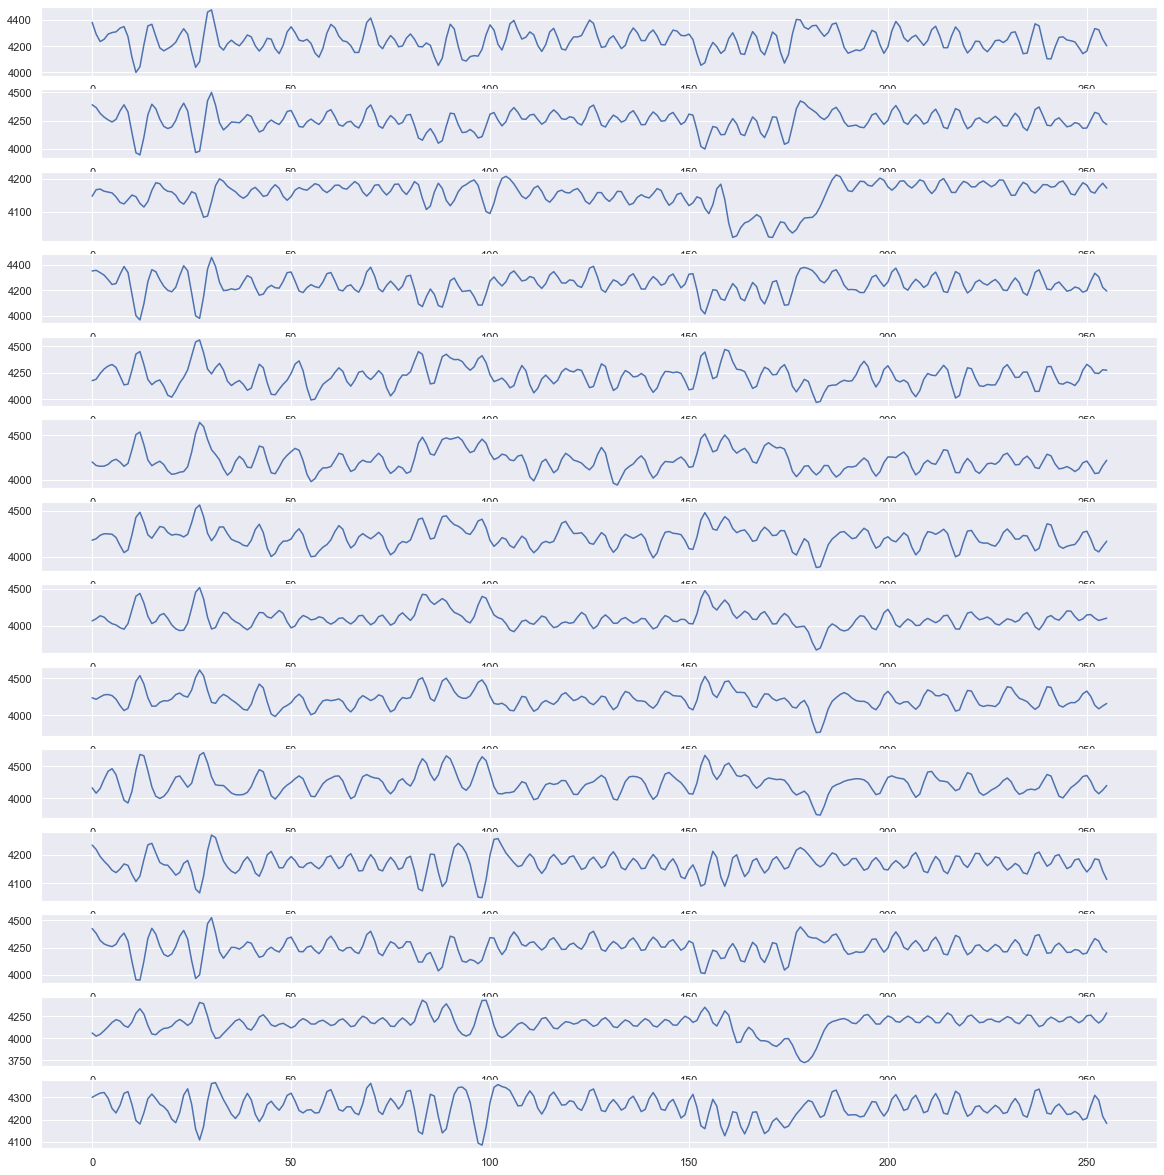

In [23]:
fig, axes = plt.subplots(len(electrodos), 1, figsize = (20, int(len(electrodos)*1.5)))

for p in range(len(electrodos)):
    axes[p].plot(datos[:,p])

<img src="https://www.researchgate.net/publication/329568433/figure/fig3/AS:702680376827906@1544543465572/The-electrode-locations-of-the-14-channel-Emotiv-EEG-headset.ppm" width="300"/>

In [24]:
# Ponerse el Emotiv y prepararse para realizar 2 acciones elegidas

X = []

for a in range(1, acciones+1):
    
    print(f'*'*10)
    print(f' Acción {a} en 5...')
    print(f'*'*10)
    
    sleep(3)
    b.beep(frequency=440, secs=0.25, blocking=True)
    for i in range(n):
        dato = eeg.get_data(muestreo * s)
        #dato = butter_bandpass_filter(dato, 8.0, 15.0, muestreo, order=6)
        #dato = dato - dato.mean(0)
        X.append(dato)
        print(i, end=' ')
        
    print('\n')
    b.beep(frequency=440, secs=0.25, blocking=True)
    b.beep(frequency=530, secs=0.5, blocking=True)

print(f'*'*10)
print(f' Terminado!')
print(f'*'*10)

**********
 Acción 1 en 5...
**********
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 

**********
 Acción 2 en 5...
**********
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 

**********
 Terminado!
**********


In [40]:
with open('X.pkl', 'rb') as f:
    X = pickle.load(f)

In [41]:
X = np.array(X)
y = np.concatenate([np.zeros(n), np.ones(n)])

In [42]:
n_components = 3
clasificador = make_pipeline(Covariances(),
                            XdawnCovariances(n_components),
                            TangentSpace(metric='riemann'),    
                            
                            # CatBoostClassifier(
                            #   loss_function='', 
                            #    depth=8, 
                            #    learning_rate=0.4,
                            #    iterations=150,
                            #    silent=True)
                            
                            LogisticRegression()
                            #TSclassifier()
                            #MDM()
                            )

In [43]:
#(trials, channels, samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_test.shape

ValueError: Found input variables with inconsistent numbers of samples: [240, 118]

In [30]:
clasificador.fit(X_train, y_train)
preds = clasificador.predict(X_test)

In [31]:
score = np.mean(preds == y_test)
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (score, class_balance))

Classification accuracy: 0.895833 / Chance level: 0.500000


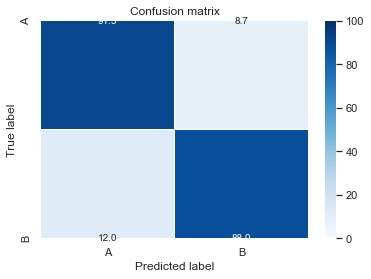

In [32]:
plot_confusion_matrix(preds, y_test, ['A', 'B']);

In [34]:
t = 100
step = 5
mouse.move_mouse(w//2, h//2)
for n in range(t):
    x, y = mouse.get_mouse_position()
    
    dato = eeg.get_data(muestreo * s)
    #dato = butter_bandpass_filter(dato, 8.0, 15.0, muestreo, order=6)
    #dato = dato - datos.mean(0)
    prob = clasificador.predict_proba(np.array([dato]))[0][0]
        
    if prob > 0.9:
        print(f'*'*10)
        print(f' Acción 1')
        print(f'*'*10)
        mouse.move_mouse(x, y+step)
        b.beep(frequency=880, secs=0.25, blocking=True)
    
    elif prob < 0.1:
        print(f'*'*10)
        print(f' Acción 2')
        print(f'*'*10)
        mouse.move_mouse(x, y-step)        
        b.beep(frequency=440, secs=0.25, blocking=True)
    
    if n % 20 == 0:
        mouse.move_mouse(w//2, h//2)
    clear_output()  
    
    print('\n')
    sleep(1)

KeyboardInterrupt: 

In [100]:
s = 60
data = eeg.get_data(muestreo * s)


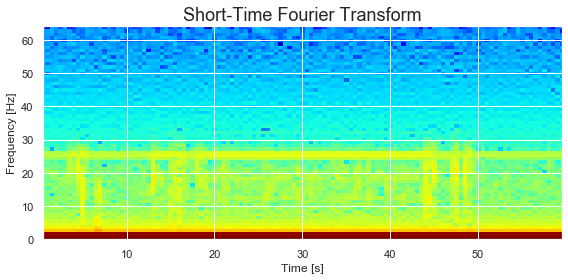

In [101]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
P, freqs, t, im = plt.specgram(data[:,1], NFFT=128, Fs=muestreo, noverlap = 64, cmap=plt.cm.jet)
ax1.set_title('Short-Time Fourier Transform', fontsize=18)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(t[0], t[-1])
plt.tight_layout()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

t2, freqs2 = np.meshgrid(t, freqs)

fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(t2, freqs2, P, rstride=1, cstride=1, cmap=plt.cm.jet,
                       linewidth=0, antialiased=False)

#ax.set_xlim(t[0], t[-1])
#ax.set_ylim(0, 500)
#ax.set_zlim(np.min(P), np.max(P))
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Frequency [Hz]', fontsize=12)
ax.set_zlabel('Power', fontsize=12)
ax.set_title('Short-Time Fourier Transform', fontsize=16, y=1.04)
ax.view_init(30, 60)